In [1]:
import torch
from torchvision import ops
from PIL import Image, ImageDraw, ImageFont
from typing import Tuple
import random
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import copy
import cv2

In [2]:
def plot_img(img, size=(8, 8)):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#### Text on image

In [3]:
from src.gen_box import gen_imgInteval, random_multi_boxes, box_gen
from src.gen_color import gen_text_color_v2, gen_text_color
from src.fill_text import fill_text_to_image, draw_rectangle
import numpy as np


In [4]:
def text_gen():
    #Texts load
    texts_path = "./train_trg.txt"
    with open(texts_path,"r",encoding="utf-8") as f:
        text = random.choice(f.readlines()).strip('\n')
        # texts_data = [x.strip('\n') for x in f.readlines()]
    
    return text
def random_multi_boxes(image_size, 
                       imageIntegral: np.ndarray,
                       n: int, 
                       font: ImageFont, 
                       scale = (0.05, 0.5),
                       font_range = (10, 100),
                       max_intergral = 20):
    #Gen random multi rectangle box on image
    boxes_dict_list = [box_gen(image_size = image_size,
                                imageIntegral = imageIntegral,
                                text = text_gen(),
                                font = font,
                                scale = scale,
                                font_range = font_range,
                                max_intergral = max_intergral) for _ in range(n)]
    boxes_dict_list = [x for x in boxes_dict_list if x['box'] is not None]
    if len(boxes_dict_list) < 1:
        return []
    rois = torch.tensor([x["box"] for x in boxes_dict_list])
    scores = torch.randn(rois.shape[0])
    keep = ops.nms(rois, scores, 0)
    # rois = rois[keep].type(torch.long)
    boxes_dict_list = [boxes_dict_list[i] for i in keep.tolist()] 
    return boxes_dict_list
    
def plot_img(img, size=(8, 8)):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()




In [5]:
font_path = "./data/font/Archivo-Regular.ttf"
bg_path = "./data/background/000000579902.jpg"
MAX_SIZE = (2048, 2048)
image = Image.open(bg_path)
image.thumbnail(MAX_SIZE)
print(image.size)
np_image = np.array(image)
w, h = image.size
font = ImageFont.truetype(font_path, size=50)

(556, 640)


In [6]:
imageIntegral = gen_imgInteval(np_image)

In [7]:
boxes_dict = random_multi_boxes(image_size = image.size, 
                    imageIntegral = imageIntegral,
                    n = 50, 
                    font = font,
                    scale = (0.02, 0.3),
                    font_range = (5, 100),
                    max_intergral = 50)

# boxes_dict

In [10]:
new_boxes_dict = []
for box_dict in boxes_dict:
    bbox = box_dict['box']
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[2])
    y2 = int(bbox[3])
    # box_dict['text_color'] = gen_text_color(np_image[y1:y2, x1:x2], max_diff = 5)
    box_dict['text_color'] = gen_text_color_v2(np_image[y1:y2, x1:x2], min_text_bg_rate = 3)
    if box_dict['text_color'] is None:
        continue
    else:
        new_boxes_dict.append(box_dict)
    
len(new_boxes_dict)

19

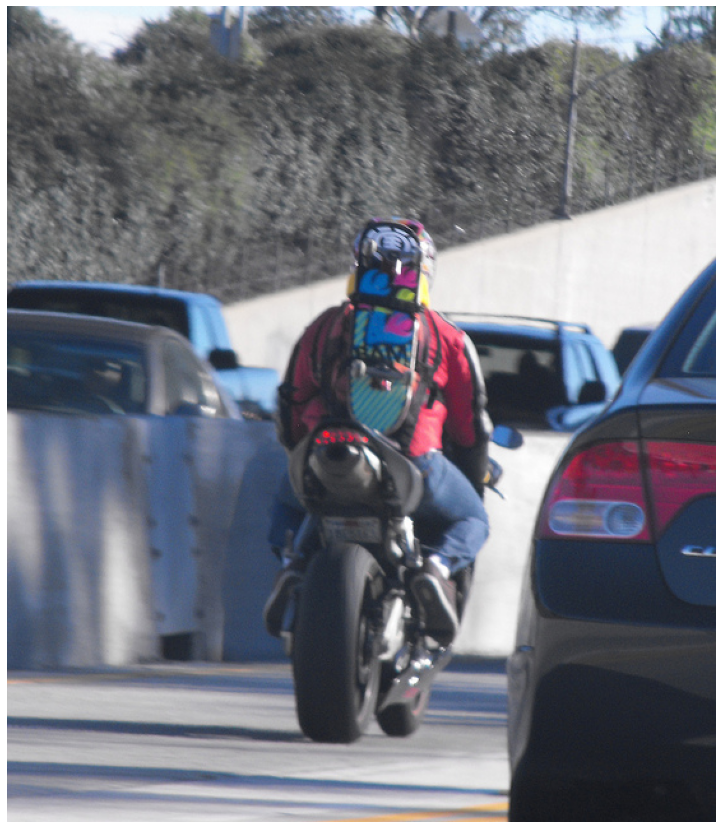

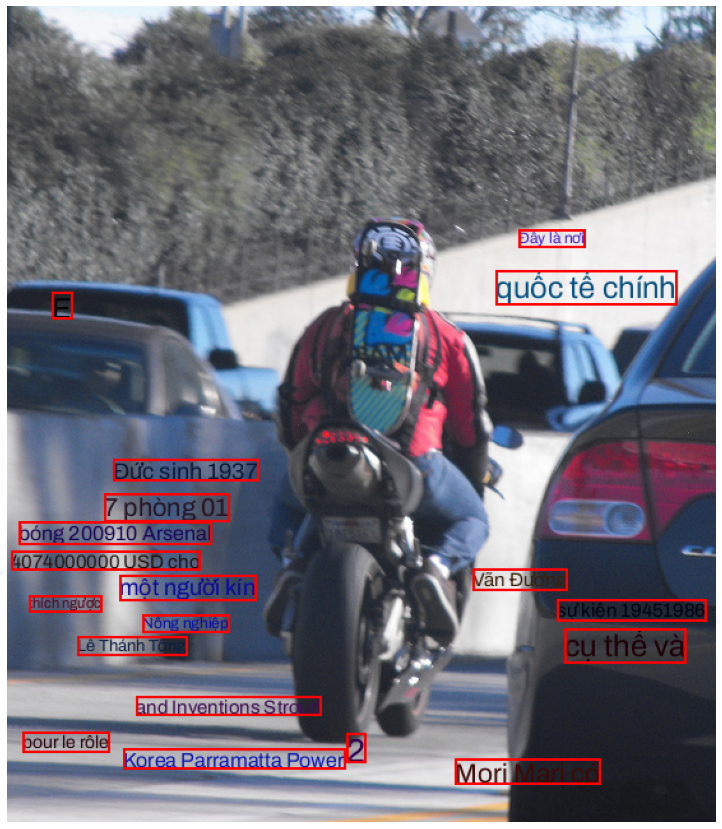

In [11]:
image_copy = image.copy()
plot_img(image_copy, (15, 15))

for box_dict in new_boxes_dict:
    image_copy = fill_text_to_image(image = image_copy,
                       text = box_dict['text'],
                       font = box_dict['font'],
                       textsize = box_dict['fontsize'],
                       box = box_dict['box'],
                       text_color = box_dict['text_color']
                        )
    box = [int(x) for x in box_dict['box'] ]
    image_copy = draw_rectangle(image_copy, box[0], box[1], box[2], box[3], line_width = 2)
plot_img(image_copy, (15, 15))
